<a href="https://colab.research.google.com/github/KWANGJAEIM/AI_project/blob/main/%EC%83%81%EC%B6%94%EC%83%9D%EC%9E%A5%EC%98%88%EC%B8%A1ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [285]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [286]:
cd "./drive/My Drive/Data/lettuce"

[Errno 2] No such file or directory: './drive/My Drive/Data/lettuce'
/content/drive/My Drive/Data/lettuce


In [287]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [288]:
# -*- coding: utf-8 -*-
# General Library
import warnings
warnings.filterwarnings('ignore')

import os, sys
import random
import numpy as np
import pandas as pd
from time import time
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import lightgbm as lgb

# Setting Random Seed
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

#########################################################################################################
DATA_DIR = 'lettuce/'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

RESULTS_DIR = 'results/'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

TEST_OUTPUT = 'answer_example.csv'

#########################################################################################################
NUM_BOOST_ROUNDS = 100
METRIC = 'fair'

categoricals = []
FEATURES =['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량']
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Python: %s'%sys.version)

Numpy: 1.21.6
Pandas: 1.3.5
LightGBM: 3.3.2
Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [289]:
def day_average(x):
    col_ave = ['DAT','내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량','시간당백색광량', '시간당적색광량','시간당청색광량','시간당총광량']
    
    x_ave_total = pd.DataFrame(columns = col_ave)
    
    for i in range(0,28):
        x_ave = x.copy(deep = True)
        x_ave = x_ave[col_ave]
        x_ave = x_ave.loc[x['DAT']==i]
        x_ave = x_ave.mean()
        # x_ave= pd.Series(x_ave)
        x_ave = pd.DataFrame(x_ave).transpose()
        x_ave_total = pd.concat([x_ave_total,x_ave], axis= 0,ignore_index= True)
    x_ave_total.columns= list(map(lambda x: x+'_ave' if x!='DAT' else 'DAT',col_ave ))  
    x_ave_total.set_index('DAT',inplace= True)      
    return x_ave_total


def day_max(x):
    col_max = ['DAT','내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량','시간당백색광량', '시간당적색광량','시간당청색광량','시간당총광량','일간누적분무량',  '일간누적백색광량',  '일간누적적색광량', '일간누적청색광량',  '일간누적총광량']
    x_max_total = pd.DataFrame(columns = col_max)
    
    
    for i in range(0,28):
        x_max = x.copy(deep = True)
        x_max = x[col_max]
        x_max = x_max.loc[x['DAT']==i]
        x_max = x_max.max()
        # x_max= pd.Series(x_max)
        x_max = pd.DataFrame(x_max).transpose()
        x_max_total = pd.concat([x_max_total,x_max], axis= 0,ignore_index= True)
    x_max_total.columns= list(map(lambda x: x+'_max' if x!='DAT' else 'DAT',col_max )) 
    x_max_total['DAT'] =range(0,28)
   
    x_max_total.set_index('DAT',inplace= True)       
    return x_max_total


def day_min(x):
    col_min = ['DAT','내부온도관측치', '내부습도관측치', 'co2관측치']
    x_min_total = pd.DataFrame(columns = col_min)
    
    for i in range(0,28):
        x_min = x.copy(deep = True)
        x_min = x[col_min]
        x_min = x_min.loc[x['DAT']==i]
        x_min = x_min.min()
        # x_min= pd.Series(x_min)
        x_min = pd.DataFrame(x_min).transpose()
        x_min_total = pd.concat([x_min_total,x_min], axis= 0,ignore_index= True)
    x_min_total.columns= list(map(lambda x: x+'_min' if x!='DAT' else 'DAT',col_min ))   
    x_min_total['DAT'] =range(0,28)
    x_min_total.set_index('DAT',inplace= True)     
    return x_min_total

def day_sum(x):
    col_sum = ['DAT', '일간누적분무량',  '일간누적백색광량',  '일간누적적색광량', '일간누적청색광량',  '일간누적총광량']
    x_sum_total = pd.DataFrame(columns = col_sum)
    
    for i in range(0,28):
        x_sum = x.copy(deep = True)
        x_sum = x[col_sum]
        x_sum = x_sum.loc[x['DAT']==i]
        x_sum = x_sum.sum()
        
        x_sum = pd.DataFrame(x_sum).transpose()
        x_sum_total = pd.concat([x_sum_total,x_sum], axis= 0,ignore_index= True)
    x_sum_total.columns= list(map(lambda x: x+'_sum' if x!='DAT' else 'DAT',col_sum )) 
    x_sum_total['DAT'] =range(0,28)
    x_sum_total.set_index('DAT',inplace= True)   
    return x_sum_total

def get_daily_temp(x):
    group = x.copy(deep = True)
    x['내부기온일교차'] = group.내부온도관측치.max()- group.내부온도관측치.min()

    x['최고온도'] = group.내부온도관측치.max()

    x['최저온도'] = group.내부온도관측치.min()

    return x 

def get_light_ratio(x):
    col_light = ['DAT','시간당총광량','시간당적색광량','시간당청색광량','시간당백색광량']
    col_ratio= ['DAT','적색/총','청색/총','백색/총']   
    x_light_total = pd.DataFrame(columns = col_ratio)
    for i in range(0,28):
        x_light = x.copy(deep = True)
        x_light= x_light[x_light['시간당총광량']!=0]
        x_light = x_light.loc[x['DAT']==i]
        x_light['적색/총'] =x_light.시간당적색광량 /x_light.시간당총광량
        x_light['청색/총'] =x_light.시간당청색광량 /x_light.시간당총광량
        x_light['백색/총'] =x_light.시간당백색광량 /x_light.시간당총광량
            
        x_light= x_light[col_ratio]
        x_light_total = pd.concat([x_light_total,x_light], axis= 0,ignore_index= True)   
            
    return x_light_total
    




In [290]:
lettuce =pd.read_csv("train_input/CASE_02.csv")
lettuce.set_index('DAT',inplace= True)
lettuce.reset_index(inplace=True)



In [291]:
lettuce = lettuce[lettuce['DAT']==1]
lettuce_max = lettuce.max()
lettuce_max= pd.DataFrame(lettuce_max)
lettuce_max.transpose()

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,1,23:00:00.,26.26,64.596666,633.2,3.114597,123.4,2221.2,0,0,4881.66,58316.8068,4621.175,55205.0265,9502.835,113521.8333


In [292]:
class LoadData(object):

    def __init__(self, DataType='train', TestNo=1):
        """
        DataType에 따라 폴더이름과 파일목록을 만든다.
        DataType: 'train', 'test' 둘 중 하나를 지정한다.
        TestNo: test case 번호를 지정한다. DataType이 'test'인 경우에만 사용된다.
        """
        self.DataType = DataType
        self.TestNo   = TestNo
        if (DataType == 'train'):
            self.x_dir = 'train_input'
            self.y_dir = 'train_target'
            self.x_list = sorted(glob(self.x_dir + '/*.csv'))
            self.y_list = sorted(glob(self.y_dir + '/*.csv'))
        else:
            self.x_dir = 'test_input'
            self.y_dir = 'test_target'
            self.x_list = sorted(glob(self.x_dir + f'/TEST_{TestNo:02d}.csv'))
            self.y_list = sorted(glob(self.y_dir + f'/TEST_{TestNo:02d}.csv'))
        return

    def read_train_raw(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = pd.read_csv(x_file), pd.read_csv(y_file)

            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
        x_df.set_index('DAT', inplace=True) 


        return x_df, y_df

    def read_data(self, x_file, y_file):
        x_df = pd.DataFrame()
        x_df = pd.read_csv(x_file)
        y_df = pd.read_csv(y_file)
          
        # if (self.DataType == 'train'):
        #     # train_y에서만 시간을 index로 설정하고, test_y에서는 submit할 때 사용하기 때문에 시간을 변환하거나 인덱스로 설정하지 않는다.
        #     y_df.set_index('DAT', inplace=True)

        x_df = pd.concat([day_average(x_df),day_max(x_df),day_min(x_df)],axis = 1)
        x_df['내부기온일교차'] = x_df.내부온도관측치_max- x_df.내부온도관측치_min
        x_df['적색/총_ave'] =x_df.시간당적색광량_ave /x_df.시간당총광량_ave
        x_df['청색/총_ave'] =x_df.시간당청색광량_ave /x_df.시간당총광량_ave
        x_df['백색/총_ave'] =x_df.시간당백색광량_ave /x_df.시간당총광량_ave
        x_df = x_df.drop(columns =['시간당백색광량_ave', '시간당적색광량_ave', '시간당청색광량_ave', '시간당총광량_ave','시간당백색광량_max', '시간당적색광량_max', '시간당청색광량_max', '시간당총광량_max'])
        x_df.reset_index(inplace=True)
        # x_df = x_df[x_df['DAT']!=0]
        x_df.set_index('DAT',inplace= True)
        y_df.set_index('DAT',inplace= True)
        # y_df_diff = y_df.diff(axis = 0)
        # y_df_diff= y_df_diff.dropna()
        return x_df, y_df

    def read_train(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        hdfile = DATA_DIR + f'train.h5'                                         # 'data/train.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = self.read_data(x_file, y_file)

            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)

        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        

        
        return x_df, y_df

    def read_test(self):
        """
        test데이터를 읽어서 X와 y를 돌려준다.
        test데이터의 01에서 06까지의 번호는 class생성시 지정된 TestNo를 사용한다.
        """
        hdfile = DATA_DIR + f'test_{self.TestNo}.h5'                            # 'data/test_n.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_file = self.x_dir + f'/TEST_{self.TestNo:02d}.csv'
        y_file = self.y_dir + f'/TEST_{self.TestNo:02d}.csv'

        x_df, y_df = self.read_data(x_file, y_file)

        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        
        return x_df, y_df

    def read(self):
        """
        class생성시 지정된 DataType에 따라서, train데이터나 test데이터를 읽어서 돌려준다.
        """
        if (self.DataType == 'train'):
            return self.read_train()
        else:
            return self.read_test()


def load_train():
    """
    LoadData('train') 클래스를 만들고 read()를 호출해서 train데이터를 읽어서 돌려준다.
    """
    train_x, train_y = LoadData('train').read()
    return train_x, train_y

def load_test(TestNo=1):
    """
    LoadData('test', TestNo) 클래스를 만들고 read()를 호출해서 test데이터를 읽어서 돌려준다.
    """
    test_x, test_y  = LoadData('test', TestNo).read()
    return test_x, test_y

def  load_spilit_train():
    """
    train데이터를 읽은 후, train_y에 log1p()를 적용시켜 데이터 평활화를 시킨다.
    train_x와 train_y의 20%로 tst_x, tst_y(테스트데이터)를 만들고, 나머지 80%의 20%로 다시 val_x, val_y(검증데이터)를 만든다.
    """
    train_x, train_y = load_train()

    train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y   



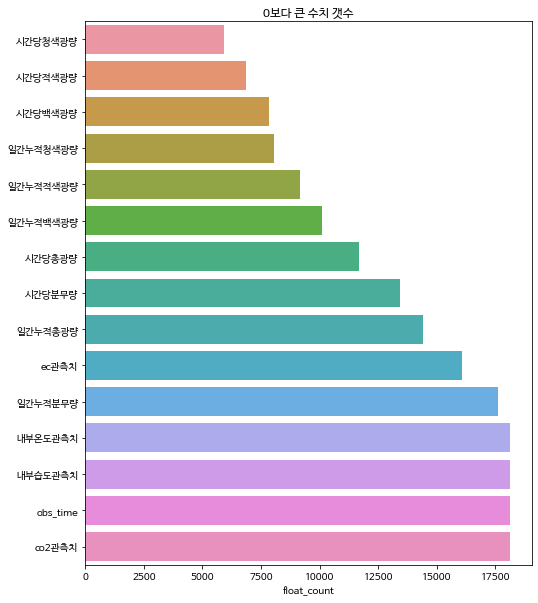

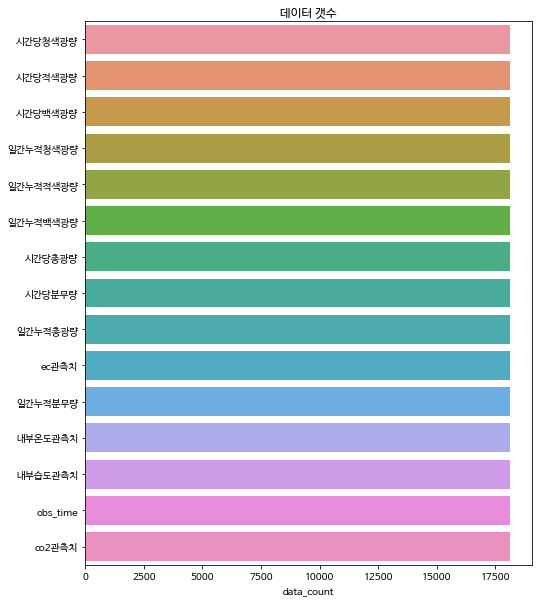

In [293]:
train_x, train_y = LoadData('train').read_train_raw()                           # train데이터를 전처리 없이 읽어온다.

data_count = (train_x.isnull()==False).sum()
null_count = (train_x.isnull()==True).sum()
float_count = (train_x.fillna(0).astype(bool)).sum()
data = [null_count, float_count, data_count]
index = ['null_count','float_count','data_count']
df = pd.DataFrame(data=data, index=index).T

df = df.sort_values('float_count')                                              # 수치 갯수 순으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('0보다 큰 수치 갯수')
sns.barplot(y=df.index, x=df['float_count'])                                    # 막대그래프를 그린다.
plt.show()

df = df.sort_values('data_count')                                               # 데이터 갯수 기준으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('데이터 갯수')
sns.barplot(y=df.index, x=df['data_count'])                                     # 막대그래프를 그린다.
plt.show()

In [304]:
X,y = LoadData('train').read_train() 



DAT
0.0      3961.27
1.0      3980.56
2.0      4093.70
3.0      3980.56
4.0      3935.55
          ...   
23.0    21634.74
24.0    21521.60
25.0    20580.22
26.0    20468.31
27.0    18845.49
Name: 일간누적분무량_max, Length: 756, dtype: float64

In [307]:
X.columns

Index(['내부온도관측치_ave', '내부습도관측치_ave', 'co2관측치_ave', 'ec관측치_ave', '시간당분무량_ave',
       '내부온도관측치_max', '내부습도관측치_max', 'co2관측치_max', 'ec관측치_max', '시간당분무량_max',
       '일간누적분무량_max', '일간누적백색광량_max', '일간누적적색광량_max', '일간누적청색광량_max',
       '일간누적총광량_max', '내부온도관측치_min', '내부습도관측치_min', 'co2관측치_min', '내부기온일교차',
       '적색/총_ave', '청색/총_ave', '백색/총_ave'],
      dtype='object')

In [299]:
def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "regression",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)] if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result,
                      categorical_feature=categoricals
                      )    

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.

    pred_Y = model.predict(test_X)                                              # test_X의 label을 추론한다.

    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['prediction']) # 아니면 추론결과만 돌려준다.

    return model, evals_result, fi, cv_preds

In [300]:
def tuning_max_bin():
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

    rmse_list = []
    max_bin_list = [250, 511, 1022, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(np.expm1(tst_y), np.expm1(cv_preds['prediction'])))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

max_bin: 250. RMSE: 12.807
max_bin: 511. RMSE: 13.583
max_bin:1022. RMSE: 13.583
max_bin:2047. RMSE: 13.583
max_bin:4095. RMSE: 13.583
Best max_bin: 250


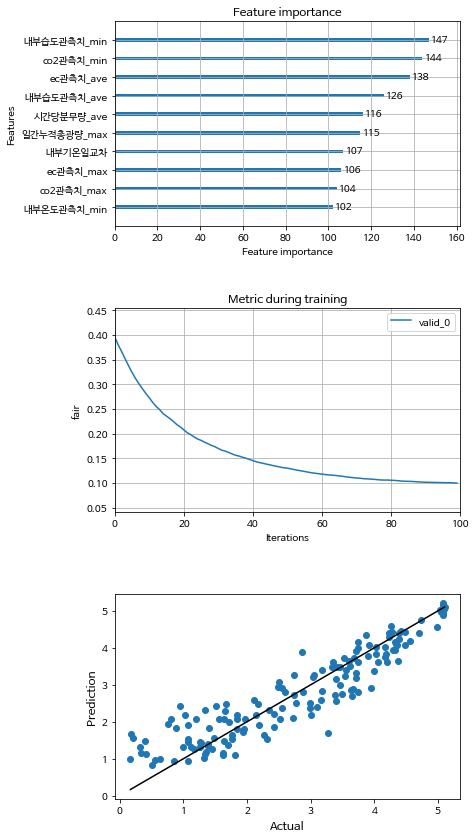

Features Importance Split & Gain...
         feature  split       gain
17    co2관측치_min    144  37.160892
16   내부습도관측치_min    147  12.503170
15   내부온도관측치_min    102   5.779283
11  일간누적백색광량_max     91   5.423594
1    내부습도관측치_ave    126   5.144850
3      ec관측치_ave    138   4.947908
5    내부온도관측치_max     94   4.815341
6    내부습도관측치_max    101   4.099816
4     시간당분무량_ave    116   3.757170
14   일간누적총광량_max    115   3.479535
0    내부온도관측치_ave     84   2.316904
18       내부기온일교차    107   2.299688
8      ec관측치_max    106   1.631196
7     co2관측치_max    104   1.389913
2     co2관측치_ave     67   1.323922
12  일간누적적색광량_max     37   1.196707
13  일간누적청색광량_max     35   0.776920
19      적색/총_ave     26   0.751206
21      백색/총_ave     15   0.742046
9     시간당분무량_max     18   0.388751
20      청색/총_ave      9   0.071189
10   일간누적분무량_max      0   0.000000
MAE:  8.511, MSE: 164.027, RMSE: 12.807


In [301]:
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


max_bin = tuning_max_bin()
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

params = {'max_bin':max_bin, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [302]:
max_bin = tuning_max_bin()
train_x, train_y = load_train()

RepNo = 5                                                                       # 품목 갯수
for rep in range(1, RepNo+1):
    print(f"Learning and Predicting for RepNo: {rep}")
    test_x, test_y = load_test(TestNo=rep)

    if (rep == 1):                                                              # 학습은 첫번째에만 하도록 한다.
        model, _, _, cv_preds = run_lgb({'max_bin':max_bin}, train_x, train_y, None, None, test_x, None)
        pred_Y = cv_preds.values
    else:
        pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

    test_y['rate'] = pred_Y
    test_y.to_csv(RESULTS_DIR + f'TEST_{rep:02d}.csv')

import zipfile
os.chdir(RESULTS_DIR)
submission = zipfile.ZipFile("submission.zip", 'w')
for rep in range(1, RepNo+1):
    path = f'TEST_{rep:02d}.csv'
    submission.write(path)
submission.close()
print(f'Saved {RESULTS_DIR}submission.zip')
os.chdir("..")

max_bin: 250. RMSE: 12.807
max_bin: 511. RMSE: 13.583
max_bin:1022. RMSE: 13.583
max_bin:2047. RMSE: 13.583
max_bin:4095. RMSE: 13.583
Best max_bin: 250
Learning and Predicting for RepNo: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p